# DDQN aplicado al entorno de Lunar Lander v2 (OpenAI-gym)

In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

In [2]:
import random
import numpy as np

In [3]:
import gym
from collections import deque

## Definir la clase Agente

Nota: Actualmente se presenta una red de tres capas (input, hidden, y output); sin embargo, durante los experimentos se probaron diferentes topologias.

In [4]:
class DDQNAgent:
    def __init__(self, state_size, action_size,gamma,lr,ep_dec):
        self.state_size = state_size      
        self.action_size = action_size    
        self.memory = deque(maxlen=3000) 
        self.gamma = gamma                 
        self.learning_rate = lr       
        
        self.epsilon = 1.0              
        self.epsilon_min = 0.01         
        self.epsilon_decay = ep_dec       
        self.model = self._build_model() 
        
        self.target_model = self._build_model() 
        self.update_target_model() 
       

    def _build_model(self):
       
        model = Sequential() 
        model.add(Dense(20, input_dim=self.state_size, activation='relu')) 
        model.add(Dense(20, activation='relu')) 
        model.add(Dense(self.action_size, activation='linear'))
       
        model.compile(loss='mse', optimizer = Adam(lr=self.learning_rate)) 
        return model
    
    # Metodo para copiar los pesos de model a target_model
    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    def remember(self, state, action, reward, next_state, done): 
        self.memory.append((state, action, reward, next_state, done))
 
    def get_action(self, state):
        if np.random.rand() <= self.epsilon: 
            return random.randrange(self.action_size)
        action_values = self.model.predict(state)
        return np.argmax(action_values[0]) 

    def replay(self, batch_size): 
        minibatch = random.sample(self.memory, batch_size) 
        
        for state, action, reward, next_state, done in minibatch:
            
            target = self.model.predict(state)
            
            if done:
                target[0][action] = reward   
            else: 
                Qvals_next_state = self.target_model.predict(next_state)[0]
                target[0][action] = reward + self.gamma * np.amax(Qvals_next_state)
 
            self.model.fit(state, target, epochs=1, verbose=0)

        if self.epsilon > self.epsilon_min: 
            self.epsilon *= self.epsilon_decay

    def load(self, name):
        self.model.load_weights(name)

    def save(self, name):
        self.model.save_weights(name)


## Definir los hiperparametros 

In [15]:
done = False
batch_size = 200 
EPISODES = 100
GAMMA=0.95
LEARNING_RATE=0.01
EP_DEC=0.995

In [16]:
env = gym.make('LunarLander-v2') #Nota, para poder trabajar con el enviroment LunarLander hay que instalar la extencion Box2D de gym
#Utilizar pip install Box2D

In [17]:
state_size = env.observation_space.shape[0]
action_size = env.action_space.n


In [18]:
agent = DDQNAgent(state_size, action_size,GAMMA,LEARNING_RATE,EP_DEC)  

In [20]:
from time import time

In [21]:
start_time = time()
for e in range(EPISODES): 
    state = env.reset() 
    state = np.reshape(state, [1, state_size])
    acc_s=0
    #La variable acc_s se utilizara para guardar un acumulado de los rewards conseguidos en cada paso, el score se basara en este acumulado
    for step in range(300):  #En este enviroment se utiliza solamente 300 steps para que la nave no se estanque volando sin rumbo
        env.render()  
        action = agent.get_action(state)  
        next_state, reward, done, _ = env.step(action)
        acc_s+=reward
        next_state = np.reshape(next_state, [1, state_size])
        agent.remember(state, action, reward, next_state, done) 
        state = next_state  
        if done: 
            agent.update_target_model()  
            print("episode: {}/{}, score: {}, e: {:.2}".format(e, EPISODES, acc_s, agent.epsilon))
            break
    if len(agent.memory) > batch_size: 
        agent.replay(batch_size)
env.close()
print(time()-start_time)

episode: 0/100, score: -191.6576480280395, e: 1.0
episode: 1/100, score: -139.0151978894143, e: 1.0
episode: 2/100, score: -59.85937805177992, e: 1.0
episode: 3/100, score: -77.55286099637524, e: 0.99
episode: 4/100, score: -306.97077207199413, e: 0.99
episode: 5/100, score: -85.1202872139838, e: 0.99
episode: 6/100, score: -306.91651888407443, e: 0.98
episode: 7/100, score: -310.7851156774142, e: 0.98
episode: 8/100, score: -113.09521252164593, e: 0.97
episode: 9/100, score: -122.61248263248723, e: 0.97
episode: 10/100, score: -258.0329200762476, e: 0.96
episode: 11/100, score: -101.74740239372957, e: 0.96
episode: 12/100, score: -320.5832839249805, e: 0.95
episode: 13/100, score: -91.95386178686606, e: 0.95
episode: 14/100, score: -384.82634823168024, e: 0.94
episode: 15/100, score: -218.26939388201356, e: 0.94
episode: 16/100, score: -204.1476064158213, e: 0.93
episode: 17/100, score: -396.24144612985725, e: 0.93
episode: 18/100, score: -114.16517757226056, e: 0.92
episode: 19/100, 

## Prueba con el modelo entrenado

In [63]:
def play_Llander(agent, trials = 1):
    env = gym.make('LunarLander-v2')  
    scores = []
    for trial in range(trials):
        score = 0
        game_memory = []
        state = []
        env.reset()
        for step in range(300):
            env.render()
            if len(state) == 0:   
                action = random.randrange(0,4)
            else:
                action_values = agent.model.predict(state.reshape(1, 8)) 
                action = np.argmax(action_values[0])     

            next_state, reward, done, _  = env.step(action) 
            score += reward 
            state = next_state
            game_memory.append([next_state, action])
            if done: 
                break
        print("Play {}/{}, score: {}".format(trial, trials, score))
        scores.append(score)
    env.close()
    print("Score medio = {}".format(sum(scores) /float(trials)) )

In [64]:
TRIALS=5
play_Llander(agent,TRIALS)

Play 0/5, score: -158.70174858335616
Play 1/5, score: -144.3998070516402
Play 2/5, score: -179.1531633763765
Play 3/5, score: -150.24641340696425
Play 4/5, score: -165.01081464681744
Score medio = -159.50238941303093


In [7]:
with open('scores.txt') as f:
    dct = f.read()
    exec(f'scores = {dct}')

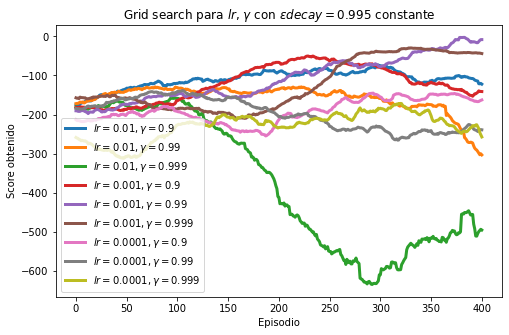

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Para suavizar las curvas de aprendizaje, se empleó
# una media movil de N términos.
N = 100

# Mostrando las curvas
plt.figure(figsize=(8, 5))
for (lr, gamma), score_hist in scores.items():
    smooth = np.convolve(score_hist, np.ones((N,)) / N, mode='valid')
    plt.plot(smooth, label=fr'$lr={lr}, \gamma={gamma}$', lw=3)

plt.legend()
plt.xlabel('Episodio')
plt.ylabel('Score obtenido')
plt.title(r'Grid search para $lr$, $\gamma$ con $\epsilon{decay}=0.995$ constante')
plt.savefig('gs.png')
plt.show()